In [1]:
!pip install -q google-cloud-storage ultralytics opencv-python-headless pandas tqdm matplotlib numpy

# Imports
import os, time, cv2, csv, shutil, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from pathlib import Path
from ultralytics import YOLO
from google.cloud import storage
from google.colab import files


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
# === CONFIG ===
BUCKET_NAME = "cctv-motion-clips-kritika-nimje"
VIDEO_EXTS = ('.mp4', '.mov', '.avi', '.mkv')
LOCAL_VIDEO_DIR = "/content/gcs_videos"
os.makedirs(LOCAL_VIDEO_DIR, exist_ok=True)

# Download service account key
uploaded = files.upload()
service_account_file = list(uploaded.keys())[0]

# Helper: connect to Google Cloud and download videos
def download_videos_from_gcs(bucket_name, local_dir, service_account_file, video_exts):
    client = storage.Client.from_service_account_json(service_account_file)
    bucket = client.bucket(bucket_name)
    blobs = list(bucket.list_blobs())
    video_blobs = [b for b in blobs if b.name.lower().endswith(video_exts)]

    for b in tqdm(video_blobs, desc="⬇️ Downloading videos"):
        local_path = os.path.join(local_dir, b.name.replace("/", os.sep))
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        if os.path.exists(local_path) and os.path.getsize(local_path) == int(b.size):
            continue
        for attempt in range(3):
            try:
                b.download_to_filename(local_path)
                break
            except Exception as e:
                print(f"⚠️ {b.name} failed ({attempt+1}/3): {e}")
                time.sleep(2 + attempt)
    print("✅ Download complete:", local_dir)

download_videos_from_gcs(BUCKET_NAME, LOCAL_VIDEO_DIR, service_account_file, VIDEO_EXTS)


Saving gcs-service-account.json to gcs-service-account.json


⬇️ Downloading videos: 100%|██████████| 25/25 [00:02<00:00,  8.74it/s]

✅ Download complete: /content/gcs_videos


In [3]:
LOCAL_MOTION_DIR = "/content/motion_frames"
os.makedirs(LOCAL_MOTION_DIR, exist_ok=True)

def detect_motion(video_path, output_folder, sensitivity=5000, skip_frames=2):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened(): return 0

    ret, prev = cap.read()
    if not ret: return 0
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

    count, saved = 0, 0
    while True:
        ret, frame = cap.read()
        if not ret: break
        if count % skip_frames != 0:
            count += 1
            continue
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        diff = cv2.absdiff(prev_gray, gray)
        if cv2.countNonZero(cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)[1]) > sensitivity:
            fname = f"{os.path.basename(video_path)}_motion_{count:05d}.jpg"
            cv2.imwrite(os.path.join(output_folder, fname), frame)
            saved += 1
        prev_gray = gray
        count += 1

    cap.release()
    return saved

# Run motion detection
total_motion_frames = 0
for root, _, files in os.walk(LOCAL_VIDEO_DIR):
    for f in files:
        if f.lower().endswith(VIDEO_EXTS):
            total_motion_frames += detect_motion(os.path.join(root, f), LOCAL_MOTION_DIR)

print(f"🎯 Total motion frames saved: {total_motion_frames}")


🎯 Total motion frames saved: 353


In [4]:
# === YOLO CONFIG ===
CONF_THRESH, IMG_SZ, DEVICE = 0.25, 640, 0

# === Load Models ===
model_weapon = YOLO("yolov8n.pt")  # default weapon detector
model_mask = YOLO("yolov8n.pt")    # same model (or custom if available)

WEAPON_CLASSES = {"knife", "gun", "pistol", "rifle", "firearm", "blade"}
MASK_CLASSES = {"mask", "with_mask", "face_mask", "masked"}

def detect_objects(videos, model, class_names, output_root, label="object"):
    os.makedirs(output_root, exist_ok=True)
    total = 0
    for video_path in videos:
        vname = Path(video_path).stem
        print(f"\n🔍 Detecting {label}s in: {vname}")
        out_dir = os.path.join(output_root, vname)
        ann_dir, crop_dir = os.path.join(out_dir, "annotated_frames"), os.path.join(out_dir, f"{label}_crops")
        os.makedirs(ann_dir, exist_ok=True)
        os.makedirs(crop_dir, exist_ok=True)
        csv_path = os.path.join(out_dir, f"{label}_detections.csv")

        with open(csv_path, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["timestamp","video","frame","class_id","name","conf","x1","y1","x2","y2","crop_path"])

            cap = cv2.VideoCapture(video_path)
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret: break
                if frame_idx % 2 != 0:
                    frame_idx += 1
                    continue
                results = model.predict(frame, imgsz=IMG_SZ, conf=CONF_THRESH, device=DEVICE, verbose=False)
                for r in results:
                    if not hasattr(r, "boxes") or len(r.boxes) == 0: continue
                    for box in r.boxes:
                        cid = int(box.cls)
                        name = model.names[cid].lower()
                        if name in class_names:
                            x1, y1, x2, y2 = map(int, box.xyxy[0])
                            crop = frame[y1:y2, x1:x2]
                            crop_path = os.path.join(crop_dir, f"{vname}_f{frame_idx}_{name}.jpg")
                            if crop.size > 0: cv2.imwrite(crop_path, crop)
                            writer.writerow([datetime.utcnow().isoformat(), vname, frame_idx, cid, name,
                                             float(box.conf), x1, y1, x2, y2, crop_path])
                            total += 1
                ann_img = r.plot()
                cv2.imwrite(os.path.join(ann_dir, f"ann_{frame_idx:06d}.jpg"), ann_img)
                frame_idx += 1
            cap.release()
    print(f"✅ Total {label} detections: {total}")

videos = [os.path.join(root, f)
          for root, _, files in os.walk(LOCAL_VIDEO_DIR)
          for f in files if f.lower().endswith(VIDEO_EXTS)]

OUTPUT_ROOT_WEAPON, OUTPUT_ROOT_MASK = "/content/weapon_detections", "/content/mask_detections"
detect_objects(videos, model_weapon, WEAPON_CLASSES, OUTPUT_ROOT_WEAPON, "weapon")
detect_objects(videos, model_mask, MASK_CLASSES, OUTPUT_ROOT_MASK, "mask")



🔍 Detecting weapons in: Cam3_2025-10-28_19-26-43

🔍 Detecting weapons in: Cam1_2025-10-12_08-25-44

🔍 Detecting weapons in: Cam3_2025-10-28_19-25-36

🔍 Detecting weapons in: Cam1_2025-11-03_08-56-01

🔍 Detecting weapons in: Cam2_2025-10-12_08-30-30

🔍 Detecting weapons in: Cam3_2025-10-28_19-26-29

🔍 Detecting weapons in: Cam3_2025-10-28_19-26-18

🔍 Detecting weapons in: Cam3_2025-10-28_19-26-52

🔍 Detecting weapons in: Cam2_2025-10-12_08-29-36

🔍 Detecting weapons in: Cam2_2025-10-12_08-35-04

🔍 Detecting weapons in: Cam2_2025-10-12_08-37-48

🔍 Detecting weapons in: Cam2_2025-10-28_19-25-54

🔍 Detecting weapons in: Cam2_2025-11-03_08-46-48

🔍 Detecting weapons in: Cam2_2025-10-12_08-28-14

🔍 Detecting weapons in: Cam2_2025-11-03_08-56-59

🔍 Detecting weapons in: Cam3_2025-10-28_19-27-14

🔍 Detecting weapons in: Cam3_2025-10-12_08-38-10

🔍 Detecting weapons in: Cam2_2025-10-12_08-26-20

🔍 Detecting weapons in: Cam1_2025-10-12_08-30-26

🔍 Detecting weapons in: Cam2_2025-10-12_08-38-19



🚶 Detecting people in Cam3_2025-10-28_19-26-43


/tmp/ipython-input-4144700721.py:28: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  w.writerow([datetime.utcnow().isoformat(), vname, frame_idx, count])



🚶 Detecting people in Cam1_2025-10-12_08-25-44

🚶 Detecting people in Cam3_2025-10-28_19-25-36

🚶 Detecting people in Cam1_2025-11-03_08-56-01

🚶 Detecting people in Cam2_2025-10-12_08-30-30

🚶 Detecting people in Cam3_2025-10-28_19-26-29

🚶 Detecting people in Cam3_2025-10-28_19-26-18

🚶 Detecting people in Cam3_2025-10-28_19-26-52

🚶 Detecting people in Cam2_2025-10-12_08-29-36

🚶 Detecting people in Cam2_2025-10-12_08-35-04

🚶 Detecting people in Cam2_2025-10-12_08-37-48

🚶 Detecting people in Cam2_2025-10-28_19-25-54

🚶 Detecting people in Cam2_2025-11-03_08-46-48

🚶 Detecting people in Cam2_2025-10-12_08-28-14

🚶 Detecting people in Cam2_2025-11-03_08-56-59

🚶 Detecting people in Cam3_2025-10-28_19-27-14

🚶 Detecting people in Cam3_2025-10-12_08-38-10

🚶 Detecting people in Cam2_2025-10-12_08-26-20

🚶 Detecting people in Cam1_2025-10-12_08-30-26

🚶 Detecting people in Cam2_2025-10-12_08-38-19

🚶 Detecting people in Cam2_2025-10-12_08-25-53

🚶 Detecting people in Cam1_2025-10-12_0

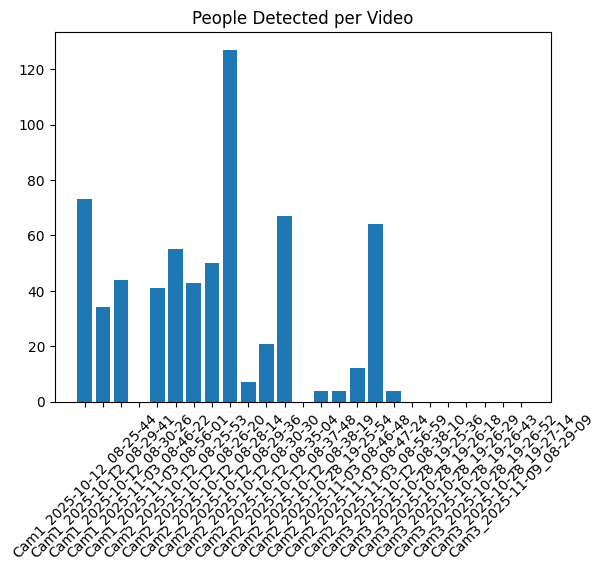

In [5]:
PERSON_OUTPUT_DIR = "/content/person_detections"
os.makedirs(PERSON_OUTPUT_DIR, exist_ok=True)
model_person = YOLO("yolov8n.pt")
PERSON_CLASS_IDS = {cid for cid, name in model_person.names.items() if name.lower() == "person"}

def detect_and_count_people(videos, model, output_root):
    data = []
    for video_path in videos:
        vname = Path(video_path).stem
        print(f"\n🚶 Detecting people in {vname}")
        out_dir = os.path.join(output_root, vname)
        os.makedirs(out_dir, exist_ok=True)
        csv_path = os.path.join(out_dir, "person_detections.csv")
        with open(csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["timestamp", "video", "frame", "count"])
            cap = cv2.VideoCapture(video_path)
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret: break
                if frame_idx % 2 != 0:
                    frame_idx += 1
                    continue
                results = model.predict(frame, imgsz=640, conf=0.25, device=0, verbose=False)
                r = results[0]
                count = sum(1 for c in r.boxes.cls if int(c) in PERSON_CLASS_IDS)
                w.writerow([datetime.utcnow().isoformat(), vname, frame_idx, count])
                data.append({"video": vname, "frame_idx": frame_idx, "person_count": count})
                frame_idx += 1
            cap.release()
    return pd.DataFrame(data)

person_df = detect_and_count_people(videos, model_person, PERSON_OUTPUT_DIR)
summary = person_df.groupby("video")["person_count"].sum().reset_index()
plt.bar(summary["video"], summary["person_count"])
plt.title("People Detected per Video")
plt.xticks(rotation=45)
plt.show()


In [6]:
FIRE_OUTPUT_DIR = "/content/fire_detections"
os.makedirs(FIRE_OUTPUT_DIR, exist_ok=True)
FIRE_CLASSES = {"fire", "smoke", "flame"}
model_fire = YOLO("yolov8n.pt")

def detect_fire_smoke(videos, model, output_root):
    total = 0
    for video_path in videos:
        vname = Path(video_path).stem
        print(f"\n🔥 Detecting fire/smoke in: {vname}")
        out_dir = os.path.join(output_root, vname)
        os.makedirs(out_dir, exist_ok=True)
        csv_path = os.path.join(out_dir, "fire_detections.csv")
        with open(csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["timestamp", "video", "frame", "class", "conf"])
            cap = cv2.VideoCapture(video_path)
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret: break
                if frame_idx % 2 != 0:
                    frame_idx += 1
                    continue
                results = model.predict(frame, imgsz=640, conf=0.25, device=0, verbose=False)
                for r in results:
                    for cid, conf in zip(r.boxes.cls, r.boxes.conf):
                        name = model.names[int(cid)].lower()
                        if name in FIRE_CLASSES:
                            w.writerow([datetime.utcnow().isoformat(), vname, frame_idx, name, float(conf)])
                            total += 1
                frame_idx += 1
            cap.release()
    print(f"🔥 Total fire/smoke detections: {total}")

detect_fire_smoke(videos, model_fire, FIRE_OUTPUT_DIR)



🔥 Detecting fire/smoke in: Cam3_2025-10-28_19-26-43

🔥 Detecting fire/smoke in: Cam1_2025-10-12_08-25-44

🔥 Detecting fire/smoke in: Cam3_2025-10-28_19-25-36

🔥 Detecting fire/smoke in: Cam1_2025-11-03_08-56-01

🔥 Detecting fire/smoke in: Cam2_2025-10-12_08-30-30

🔥 Detecting fire/smoke in: Cam3_2025-10-28_19-26-29

🔥 Detecting fire/smoke in: Cam3_2025-10-28_19-26-18

🔥 Detecting fire/smoke in: Cam3_2025-10-28_19-26-52

🔥 Detecting fire/smoke in: Cam2_2025-10-12_08-29-36

🔥 Detecting fire/smoke in: Cam2_2025-10-12_08-35-04

🔥 Detecting fire/smoke in: Cam2_2025-10-12_08-37-48

🔥 Detecting fire/smoke in: Cam2_2025-10-28_19-25-54

🔥 Detecting fire/smoke in: Cam2_2025-11-03_08-46-48

🔥 Detecting fire/smoke in: Cam2_2025-10-12_08-28-14

🔥 Detecting fire/smoke in: Cam2_2025-11-03_08-56-59

🔥 Detecting fire/smoke in: Cam3_2025-10-28_19-27-14

🔥 Detecting fire/smoke in: Cam3_2025-10-12_08-38-10

🔥 Detecting fire/smoke in: Cam2_2025-10-12_08-26-20

🔥 Detecting fire/smoke in: Cam1_2025-10-12_08

In [7]:
POSTURE_OUTPUT_DIR = "/content/posture_detections"
os.makedirs(POSTURE_OUTPUT_DIR, exist_ok=True)
model_pose = YOLO("yolov8n-pose.pt")

def classify_posture(keypoints):
    if keypoints is None or len(keypoints) < 17: return "unknown"
    try:
        left_sh, right_sh = keypoints[5], keypoints[6]
        left_hp, right_hp = keypoints[11], keypoints[12]
        left_ank, right_ank = keypoints[15], keypoints[16]
    except: return "unknown"
    torso = np.linalg.norm(np.mean([left_sh, right_sh], 0) - np.mean([left_hp, right_hp], 0))
    height = np.linalg.norm(np.mean([left_sh, right_sh], 0) - np.mean([left_ank, right_ank], 0))
    if height == 0: return "unknown"
    ratio = torso / height
    return "standing" if ratio > 0.6 else "sitting" if ratio > 0.3 else "lying"

def detect_posture(videos, model, output_root):
    summary = []
    for video_path in videos:
        vname = Path(video_path).stem
        print(f"\n🧠 Analyzing posture in {vname}")
        out_dir = os.path.join(output_root, vname)
        os.makedirs(out_dir, exist_ok=True)
        csv_path = os.path.join(out_dir, "posture_detections.csv")
        with open(csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["timestamp","video","frame","person_id","posture","conf"])
            cap = cv2.VideoCapture(video_path)
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret: break
                if frame_idx % 2 != 0:
                    frame_idx += 1
                    continue
                results = model.predict(frame, imgsz=640, conf=0.5, device=0, verbose=False)
                r = results[0]
                if r.keypoints is not None:
                    for i, kps in enumerate(r.keypoints.xy):
                        posture = classify_posture(kps.cpu().numpy())
                        conf = float(np.mean(r.keypoints.conf[i].cpu().numpy()))
                        w.writerow([datetime.utcnow().isoformat(), vname, frame_idx, i, posture, conf])
                frame_idx += 1
            cap.release()
    print("✅ Posture detection completed.")

detect_posture(videos, model_pose, POSTURE_OUTPUT_DIR)



🧠 Analyzing posture in Cam3_2025-10-28_19-26-43

🧠 Analyzing posture in Cam1_2025-10-12_08-25-44


/tmp/ipython-input-204372294.py:43: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  w.writerow([datetime.utcnow().isoformat(), vname, frame_idx, i, posture, conf])



🧠 Analyzing posture in Cam3_2025-10-28_19-25-36

🧠 Analyzing posture in Cam1_2025-11-03_08-56-01

🧠 Analyzing posture in Cam2_2025-10-12_08-30-30

🧠 Analyzing posture in Cam3_2025-10-28_19-26-29

🧠 Analyzing posture in Cam3_2025-10-28_19-26-18

🧠 Analyzing posture in Cam3_2025-10-28_19-26-52

🧠 Analyzing posture in Cam2_2025-10-12_08-29-36

🧠 Analyzing posture in Cam2_2025-10-12_08-35-04

🧠 Analyzing posture in Cam2_2025-10-12_08-37-48

🧠 Analyzing posture in Cam2_2025-10-28_19-25-54

🧠 Analyzing posture in Cam2_2025-11-03_08-46-48

🧠 Analyzing posture in Cam2_2025-10-12_08-28-14

🧠 Analyzing posture in Cam2_2025-11-03_08-56-59

🧠 Analyzing posture in Cam3_2025-10-28_19-27-14

🧠 Analyzing posture in Cam3_2025-10-12_08-38-10

🧠 Analyzing posture in Cam2_2025-10-12_08-26-20

🧠 Analyzing posture in Cam1_2025-10-12_08-30-26

🧠 Analyzing posture in Cam2_2025-10-12_08-38-19

🧠 Analyzing posture in Cam2_2025-10-12_08-25-53

🧠 Analyzing posture in Cam1_2025-10-12_08-29-41

🧠 Analyzing posture

In [8]:
# Cleanup key file
if os.path.exists(service_account_file):
    os.remove(service_account_file)
    print("🧹 Removed local service account key.")

# Zip results
shutil.make_archive("/content/weapon_detections_archive", 'zip', "/content/weapon_detections")
shutil.make_archive("/content/mask_detections_archive", 'zip', "/content/mask_detections")
shutil.make_archive("/content/person_detections_archive", 'zip', "/content/person_detections")
shutil.make_archive("/content/fire_detections_archive", 'zip', "/content/fire_detections")
shutil.make_archive("/content/posture_detections_archive", 'zip', "/content/posture_detections")

print("✅ Archives created for all detection modules — ready to download.")


🧹 Removed local service account key.
✅ Archives created for all detection modules — ready to download.


In [9]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Define output folders
FOLDERS = {
    "motion": "/content/motion_frames",
    "weapon": "/content/weapon_detections",
    "mask": "/content/mask_detections",
    "person": "/content/person_detections",
    "fire": "/content/fire_detections",
    "posture": "/content/posture_detections",
}

def load_all_detections(folders):
    data = {}
    for label, path in folders.items():
        dfs = []
        for root, _, files in os.walk(path):
            for f in files:
                if f.endswith(".csv"):
                    try:
                        df = pd.read_csv(os.path.join(root, f))
                        df["video"] = Path(root).name
                        dfs.append(df)
                    except Exception:
                        pass
        if dfs:
            data[label] = pd.concat(dfs, ignore_index=True)
            print(f"✅ Loaded {label} detections — {len(data[label])} rows")
        else:
            print(f"⚠️ No CSVs found for {label}")
    return data

detections = load_all_detections(FOLDERS)


⚠️ No CSVs found for motion
✅ Loaded weapon detections — 0 rows
✅ Loaded mask detections — 0 rows
✅ Loaded person detections — 3379 rows
✅ Loaded fire detections — 0 rows
✅ Loaded posture detections — 516 rows


/tmp/ipython-input-1532964016.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data[label] = pd.concat(dfs, ignore_index=True)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


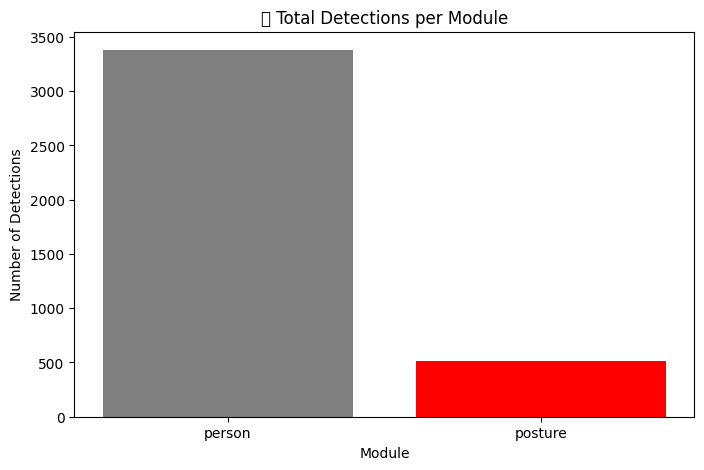

Summary Table:
Person     → 3379 detections
Posture    → 516 detections


In [10]:
summary_counts = {label: len(df) for label, df in detections.items() if not df.empty}
plt.figure(figsize=(8,5))
plt.bar(summary_counts.keys(), summary_counts.values(), color=["gray","red","blue","green","orange","purple"])
plt.title("📊 Total Detections per Module")
plt.ylabel("Number of Detections")
plt.xlabel("Module")
plt.show()

print("Summary Table:")
for k,v in summary_counts.items():
    print(f"{k.title():<10} → {v} detections")


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


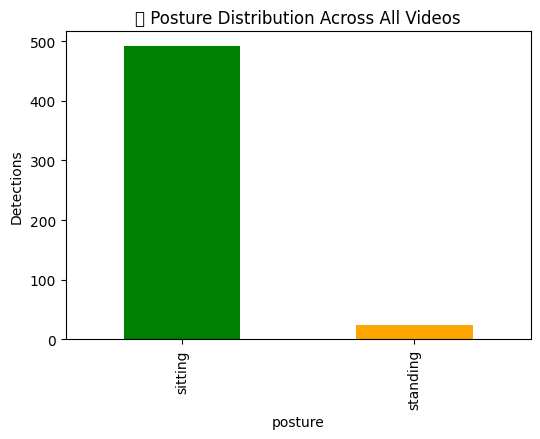

In [11]:
if "person" in detections:
    df_p = detections["person"]
    if "person_count" in df_p.columns:
        plt.figure(figsize=(10,4))
        for vid in df_p["video"].unique():
            sub = df_p[df_p["video"] == vid]
            plt.plot(sub["frame_idx"], sub["person_count"], label=vid)
        plt.title("👥 People Count Over Time")
        plt.xlabel("Frame Index")
        plt.ylabel("Person Count")
        plt.legend()
        plt.show()

if "posture" in detections:
    df_post = detections["posture"]
    posture_counts = df_post["posture"].value_counts()
    plt.figure(figsize=(6,4))
    posture_counts.plot(kind="bar", color=["green","orange","red","gray"])
    plt.title("🧍 Posture Distribution Across All Videos")
    plt.ylabel("Detections")
    plt.show()


In [12]:
compare_data = []
for label in ["fire", "weapon", "mask"]:
    if label in detections and not detections[label].empty:
        temp = detections[label].groupby("video").size().reset_index(name="count")
        temp["type"] = label
        compare_data.append(temp)

if compare_data:
    df_compare = pd.concat(compare_data)
    pivot = df_compare.pivot(index="video", columns="type", values="count").fillna(0)
    pivot.plot(kind="bar", figsize=(10,5))
    plt.title("🔥 Weapon/Mask/Fire Detections per Video")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("⚠️ No fire/weapon/mask detections available for comparison.")


⚠️ No fire/weapon/mask detections available for comparison.


/tmp/ipython-input-282152336.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-282152336.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


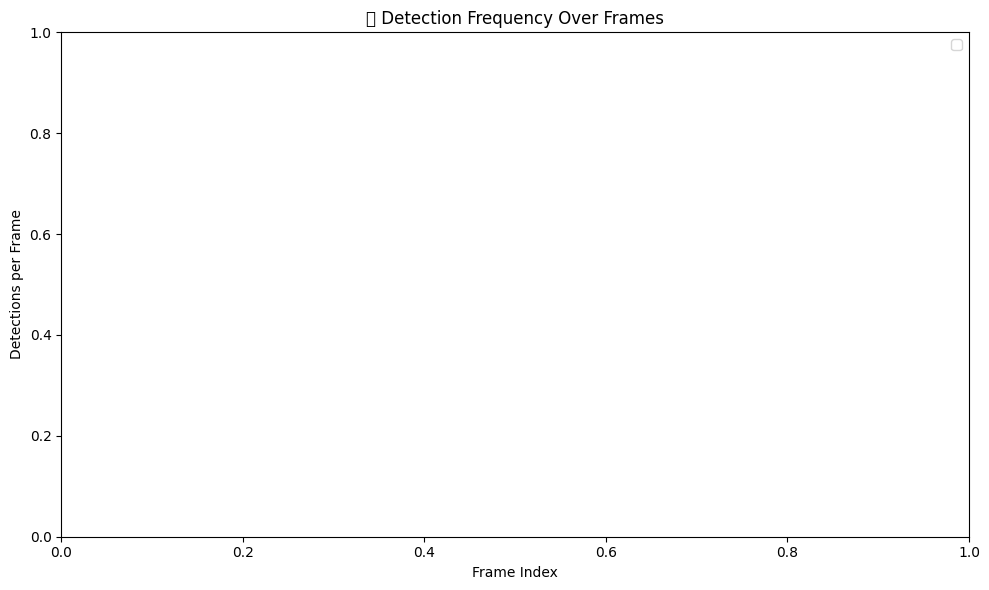

In [13]:
plt.figure(figsize=(10,6))
for label, df in detections.items():
    if "frame_idx" in df.columns:
        df_temp = df.groupby("frame_idx").size().reset_index(name="count")
        plt.plot(df_temp["frame_idx"], df_temp["count"], label=label)

plt.title("📈 Detection Frequency Over Frames")
plt.xlabel("Frame Index")
plt.ylabel("Detections per Frame")
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


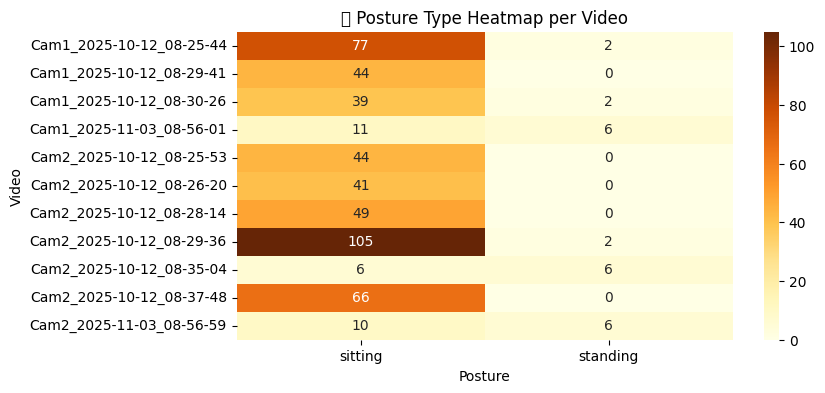

In [14]:
import seaborn as sns

if "posture" in detections:
    df_post = detections["posture"]
    pivot_posture = pd.crosstab(df_post["video"], df_post["posture"])
    plt.figure(figsize=(8,4))
    sns.heatmap(pivot_posture, annot=True, fmt="d", cmap="YlOrBr")
    plt.title("🧍 Posture Type Heatmap per Video")
    plt.ylabel("Video")
    plt.xlabel("Posture")
    plt.show()


/tmp/ipython-input-1184010788.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


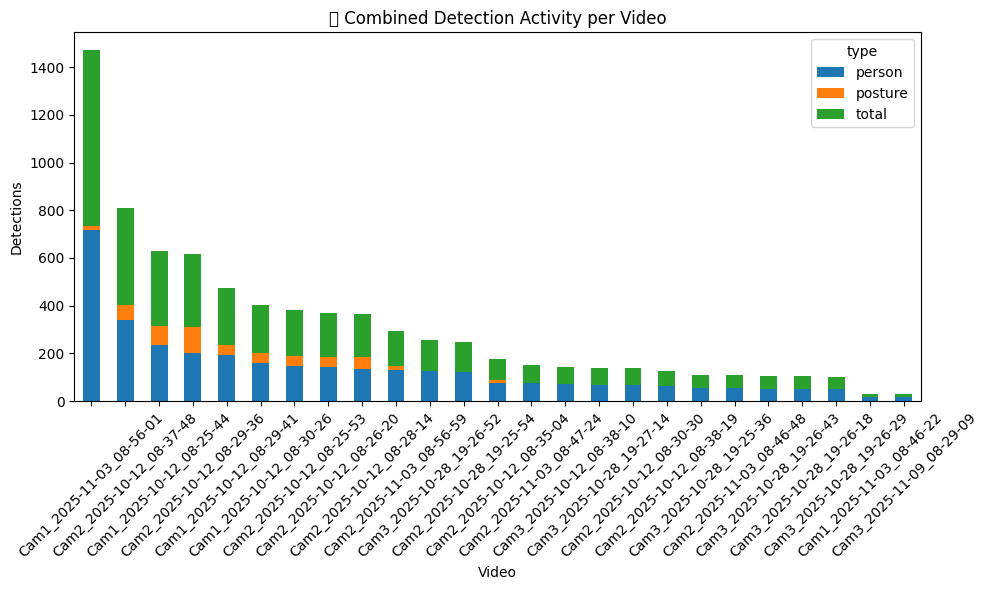

type,person,posture,total
video,,,
Cam1_2025-11-03_08-56-01,719.0,17.0,736.0
Cam2_2025-10-12_08-37-48,339.0,66.0,405.0
Cam1_2025-10-12_08-25-44,235.0,79.0,314.0
Cam2_2025-10-12_08-29-36,202.0,107.0,309.0
Cam1_2025-10-12_08-29-41,193.0,44.0,237.0
Cam1_2025-10-12_08-30-26,160.0,41.0,201.0
Cam2_2025-10-12_08-25-53,147.0,44.0,191.0
Cam2_2025-10-12_08-26-20,144.0,41.0,185.0
Cam2_2025-10-12_08-28-14,134.0,49.0,183.0


In [15]:
combined_summary = []
for label, df in detections.items():
    if "video" in df.columns:
        counts = df["video"].value_counts().to_dict()
        for video, count in counts.items():
            combined_summary.append({"video": video, "type": label, "detections": count})

df_summary = pd.DataFrame(combined_summary)
pivot_summary = df_summary.pivot_table(index="video", columns="type", values="detections", fill_value=0)
pivot_summary["total"] = pivot_summary.sum(axis=1)
pivot_summary = pivot_summary.sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
pivot_summary.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("📊 Combined Detection Activity per Video")
plt.xlabel("Video")
plt.ylabel("Detections")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(pivot_summary)


In [16]:
!pip install -q plotly
import plotly.express as px

if not df_summary.empty:
    fig = px.bar(df_summary, x="video", y="detections", color="type",
                 title="Interactive Detection Summary Dashboard",
                 barmode="stack", text="detections")
    fig.update_layout(xaxis_title="Video", yaxis_title="Number of Detections")
    fig.show()


In [17]:
!pip install -q dash dash-bootstrap-components plotly pandas

import os
import pandas as pd
from pathlib import Path
from dash import Dash, html, dcc
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 12.9 MB/s eta 0:00:00


In [18]:
# Define your detection output folders
FOLDERS = {
    "motion": "/content/motion_frames",
    "weapon": "/content/weapon_detections",
    "mask": "/content/mask_detections",
    "person": "/content/person_detections",
    "fire": "/content/fire_detections",
    "posture": "/content/posture_detections",
}

def load_detection_data():
    """Reload all detection CSVs dynamically."""
    combined = []
    for label, path in FOLDERS.items():
        for root, _, files in os.walk(path):
            for f in files:
                if f.endswith(".csv"):
                    try:
                        df = pd.read_csv(os.path.join(root, f))
                        df["video"] = Path(root).name
                        df["type"] = label
                        combined.append(df)
                    except Exception:
                        pass
    return pd.concat(combined, ignore_index=True) if combined else pd.DataFrame()


In [19]:
app = Dash(__name__, external_stylesheets=[dbc.themes.FLATLY])
app.title = "CCTV AI Dashboard"

app.layout = dbc.Container([
    html.H2("🎥 CCTV AI Analytics Dashboard", className="text-center mt-3 mb-4"),
    dbc.Row([
        dbc.Col(dcc.Graph(id="total-detections"), md=6),
        dbc.Col(dcc.Graph(id="detections-over-time"), md=6),
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id="posture-heatmap"), md=12),
    ]),
    dcc.Interval(id="interval-component", interval=10*1000, n_intervals=0)  # refresh every 10s
], fluid=True)


In [20]:
@app.callback(
    [Output("total-detections", "figure"),
     Output("detections-over-time", "figure"),
     Output("posture-heatmap", "figure")],
    Input("interval-component", "n_intervals")
)
def update_dashboard(n):
    df = load_detection_data()
    if df.empty:
        return px.bar(title="No data yet"), px.line(title="No data yet"), px.imshow([[0]])

    # --- 1️⃣ Total detections per module ---
    summary = df.groupby("type").size().reset_index(name="count")
    fig_total = px.bar(summary, x="type", y="count", color="type",
                       title="📊 Total Detections per Module",
                       text="count", color_discrete_sequence=px.colors.qualitative.Set2)

    # --- 2️⃣ Detections over time ---
    if "frame_idx" in df.columns:
        trend = df.groupby(["type", "frame_idx"]).size().reset_index(name="count")
        fig_trend = px.line(trend, x="frame_idx", y="count", color="type",
                            title="📈 Detection Frequency over Frames")
    else:
        fig_trend = px.line(title="📈 Detection Frequency (No frame_idx found)")

    # --- 3️⃣ Posture Heatmap ---
    if "posture" in df.columns:
        post = df[df["type"] == "posture"]
        heat = pd.crosstab(post["video"], post["posture"])
        fig_heat = px.imshow(heat, text_auto=True, aspect="auto",
                             title="🧍 Posture Distribution per Video", color_continuous_scale="OrRd")
    else:
        fig_heat = px.imshow([[0]], title="🧍 No Posture Data Yet")

    return fig_total, fig_trend, fig_heat
